# Create a model for learning the dynamics

## Import div stuff

In [74]:
from dnn import Net
import numpy as np
import torch
import torch.nn as nn
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load data and create datasets

The dataset is split into X and Y, where X are the "current" states of the aluminium-plant and the inputs applies, and Y is the state at next time-step. 

In [75]:
num_states = 8
num_inputs = 5

batch_size = 4

with open("PBM_simulation_data.pickle", "rb") as handle:
    data = pickle.load(handle)

data = data.reshape((-1, 13))
data /= np.mean(data.numpy(), axis=0) # Zero-mean data
X = data[:-1]
y = data[1:, :num_states]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True)

train_loader_x = iter(torch.utils.data.DataLoader(
    X_train, batch_size=batch_size, shuffle=False, num_workers=2
))
train_loader_y = iter(torch.utils.data.DataLoader(
    y_train, batch_size=batch_size, shuffle=False, num_workers=2
))
test_loader_x = iter(torch.utils.data.DataLoader(
    X_test, batch_size=batch_size, shuffle=False, num_workers=2
))
test_loader_y = iter(torch.utils.data.DataLoader(
    y_test, batch_size=batch_size, shuffle=False, num_workers=2
))


## Training

In [76]:
epochs = 100000
model = Net(num_states, num_inputs)
losses = []

for epoch in range(epochs):
    x = train_loader_x.next().to(model.device)
    y = train_loader_y.next().to(model.device)
    
    pred = model.forward(x)
    loss = nn.functional.mse_loss(pred, y)
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    losses.append(float(loss.cpu().detach().numpy()))

(0.0, 5.0)

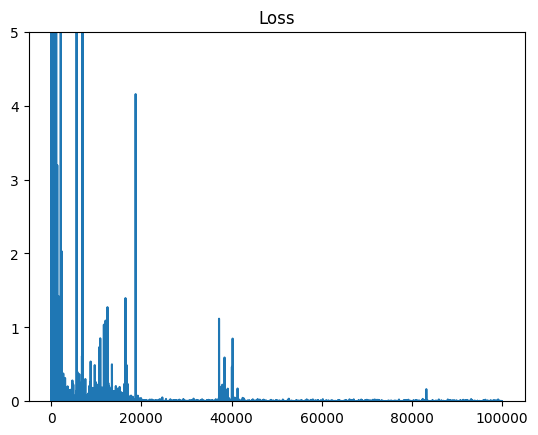

In [77]:
plt.figure("Loss")
plt.plot(range(len(losses)), losses)
plt.title("Loss")
plt.ylim((0, 5))

## Test on test set

In [78]:
num_total = 0
num_true = 0
for x_test, y_test in zip(test_loader_x, test_loader_y):
    with torch.no_grad():
        x_test = x_test.to(model.device)
        y_test = y_test.to(model.device)
        y_pred = model.forward(x_test)
        close = np.isclose(y_pred.cpu(), y_test.cpu(), rtol=0.05)
        num_true += sum(np.alltrue(close, axis=1))
        num_total += close.shape[0]
        
print("Correct:", num_true)
print("Total:", num_total)
print("Accuracy:", num_true / num_total)



Correct: 247249
Total: 250000
Accuracy: 0.988996


## Re-initialize the data-loaders

In [81]:
with open("PBM_simulation_data.pickle", "rb") as handle:
    data = pickle.load(handle)

data = data.reshape((-1, 13))
data /= np.mean(data.numpy(), axis=0) # Zero-mean data
X = data[:-1]
y = data[1:, :num_states]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True)

train_loader_x = iter(torch.utils.data.DataLoader(
    X_train, batch_size=batch_size, shuffle=False, num_workers=2
))
train_loader_y = iter(torch.utils.data.DataLoader(
    y_train, batch_size=batch_size, shuffle=False, num_workers=2
))
test_loader_x = iter(torch.utils.data.DataLoader(
    X_test, batch_size=batch_size, shuffle=False, num_workers=2
))
test_loader_y = iter(torch.utils.data.DataLoader(
    y_test, batch_size=batch_size, shuffle=False, num_workers=2
))

## Turn on regularization

Using weight decay with `lambda=1e-4` in the Adam optimizer

In [83]:
model = Net(num_states, num_inputs)
model.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

## Train again

In [84]:
epochs = 100000
model = Net(num_states, num_inputs)
losses = []

for epoch in range(epochs):
    x = train_loader_x.next().to(model.device)
    y = train_loader_y.next().to(model.device)
    
    pred = model.forward(x)
    loss = nn.functional.mse_loss(pred, y)
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    losses.append(float(loss.cpu().detach().numpy()))

In [ ]:
plt.figure("Loss")
plt.plot(range(len(losses)), losses)
plt.title("Loss")
plt.ylim((0, 5))

## Test again

In [82]:
num_total = 0
num_true = 0
for x_test, y_test in zip(test_loader_x, test_loader_y):
    with torch.no_grad():
        x_test = x_test.to(model.device)
        y_test = y_test.to(model.device)
        y_pred = model.forward(x_test)
        close = np.isclose(y_pred.cpu(), y_test.cpu(), rtol=0.01)
        num_true += sum(np.alltrue(close, axis=1))
        num_total += close.shape[0]
        
print("Correct:", num_true)
print("Total:", num_total)
print("Accuracy:", num_true / num_total)

Correct: 29473
Total: 250000
Accuracy: 0.117892
